In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv("dstest.csv")

In [3]:
df.head()

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content
0,Streamroot TV,VOD,ME1,0.0,8507376.0,0.0,0.0,1,1562469807407,120000.0,0,0,content-09235
1,Streamroot TV,VOD,ME1,0.0,5778744.0,0.0,0.0,0,1562469927310,240000.0,0,0,content-09235
2,Streamroot TV,VOD,ME1,0.0,7692960.0,0.0,0.0,0,1562470047330,360000.0,0,0,content-09235
3,Streamroot TV,VOD,ME1,0.0,8229888.0,0.0,0.0,0,1562470167720,480000.0,0,0,content-09235
4,Streamroot TV,VOD,ME1,0.0,10387000.0,0.0,0.0,0,1562470287353,600000.0,0,0,content-09235


## Question 1 
Knowing the goal of the our technology, define a metric to measure our performance. Calculate that performance score for each of the companies in the dataset.


In [4]:
# Considered useful if viewers are downloading content more from p2p than cdn
# Calling this "Utility Rate" for the p2p network

def get_utility_rate(p2p_downloads, cdn_downloads):
    # If either download is greater than 0, take ratio
    if cdn_downloads > 0 or p2p_downloads > 0:
        if cdn_downloads == 0:
            cdn_downloads = 0.0000000001 # To prevent dividing by zero
        
        ratio = p2p_downloads / cdn_downloads
        
        # Convert to values in range [0,1]
        utility_rate = np.arctan(ratio) * (2/np.pi)
        
    # If both are zero, don't take ratio
    else:
        utility_rate = np.nan
    
    return utility_rate

In [5]:
# Get performance score for each company
def utility_rate_by_company(df, company):
    p2p_downloads = df.loc[df['company'] == company, 'p2p'].sum()
    cdn_downloads = df.loc[df['company'] == company, 'cdn'].sum()
    
    utility_rate = get_utility_rate(p2p_downloads, cdn_downloads) 
    return utility_rate
    

In [6]:
for company in df.company.unique():
    print(company, 'had a performance score of', utility_rate_by_company(df, company))

Streamroot TV had a performance score of 0.5600304677186928
Flash Infos had a performance score of 0.3670744797278995
Sports News had a performance score of 0.17492937508887912


## Question 2
### 2.1
How can we know whether a payload is the first payload of a viewer’s
session?

Answer: The payload would be the first of a viewer's session if the sessionDuration is less than or equal to 2 minutes, since the payloads are sent every two minutes.

### 2.2 
Add a column `isFirstPayload` to the dataset, that must be `True` if the row represents a payload that was the first payload sent by a viewer, and `False` otherwise.

In [7]:
df['isFirstPayload'] = (df.sessionDuration <= 120000)

### 2.3
Use that column to calculate the number of distinct viewers that sent payloads for each company.

In [8]:
for company in df.company.unique():
    print(company, 'had', df.loc[df['company'] == company, 'isFirstPayload'].sum(), 'distinct viewers that sent payloads')

Streamroot TV had 19914 distinct viewers that sent payloads
Flash Infos had 805 distinct viewers that sent payloads
Sports News had 115 distinct viewers that sent payloads


## Question 3

### 3.1 
Let’s consider a viewer A who starts a video at T=0, then has a playback error at __T = 2 minutes 30 seconds__, and then another one at __T=6 minutes 20 seconds__. What will be the values of the fields `playbackErrorCount` and `totalPlaybackErrorCount` in the first 5 payloads sent by viewer A?

In [9]:
first_5 = pd.DataFrame(columns=["payload_number", "playbackErrorCount", "totalPlaybackErrorCount"], 
                              data=[[1,0,0], [2,1,1], [3,0,1], [4,1,2], [5,0,2]])

In [10]:
first_5

,payload_number,playbackErrorCount,totalPlaybackErrorCount
0,1,0,0
1,2,1,1
2,3,0,1
3,4,1,2
4,5,0,2


### 3.2 
Calculate the number of distinct viewers that had at least 1 playback error during their session.

In [11]:
print('There are', len(df[df["totalPlaybackErrorCount"] >= 1]), 'viewers that had at least 1 playback error during their session.')

There are 253 viewers that had at least 1 playback error during their session.


## Question 4

We define the _concurrency_ as the number of viewers connected simustaneously on the __same content__, i.e the number of payloads we received during a given 2 minutes window on a given content.

In [12]:
# Subset of data focused on customer, Streamr*** TV
strt_tv = df[df["company"] == 'Streamroot TV']

### 4.1 
Add a column “readableDate” to the dataset that will be the beginning of the 2 minutes window during which the payload was sent. For example, if a payload was sent at 11:35, the column “readableDate” should be 11:33.

In [13]:
# Subtract 120000 milliseconds, i.e. 2 minutes, from timestamp
strt_tv["readableDate"] = strt_tv['timestamp'] - 120000

<ipython-input-13-6ded8dfaa40b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strt_tv["readableDate"] = strt_tv['timestamp'] - 120000


In [14]:
strt_tv.head()

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content,isFirstPayload,readableDate
0,Streamroot TV,VOD,ME1,0.0,8507376.0,0.0,0.0,1,1562469807407,120000.0,0,0,content-09235,True,1562469687407
1,Streamroot TV,VOD,ME1,0.0,5778744.0,0.0,0.0,0,1562469927310,240000.0,0,0,content-09235,False,1562469807310
2,Streamroot TV,VOD,ME1,0.0,7692960.0,0.0,0.0,0,1562470047330,360000.0,0,0,content-09235,False,1562469927330
3,Streamroot TV,VOD,ME1,0.0,8229888.0,0.0,0.0,0,1562470167720,480000.0,0,0,content-09235,False,1562470047720
4,Streamroot TV,VOD,ME1,0.0,10387000.0,0.0,0.0,0,1562470287353,600000.0,0,0,content-09235,False,1562470167353


### 4.2 
Plot the concurrency time series for the content `content-05335`.

In [15]:
# Converting timestamp and readableDate to datetime objects
strt_tv['timestamp'] = pd.to_datetime(strt_tv['timestamp'], unit='ms')
strt_tv['readableDate'] = pd.to_datetime(strt_tv['readableDate'], unit='ms')

<ipython-input-15-d8c89ee4d5f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strt_tv['timestamp'] = pd.to_datetime(strt_tv['timestamp'], unit='ms')
<ipython-input-15-d8c89ee4d5f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strt_tv['readableDate'] = pd.to_datetime(strt_tv['readableDate'], unit='ms')


In [16]:
# New dataframe, grouped by content and into 2 minute intervals, to capture concurrency
concurrency_df = strt_tv.groupby(['content', pd.Grouper(key='readableDate', freq='2min')]).agg(
    p2p_total=('p2p','sum'),
    cdn_total=('cdn','sum'),
    concurrency=('content','count'))


Text(0.5, 1.0, 'Concurrency Time Series for Content-05335')

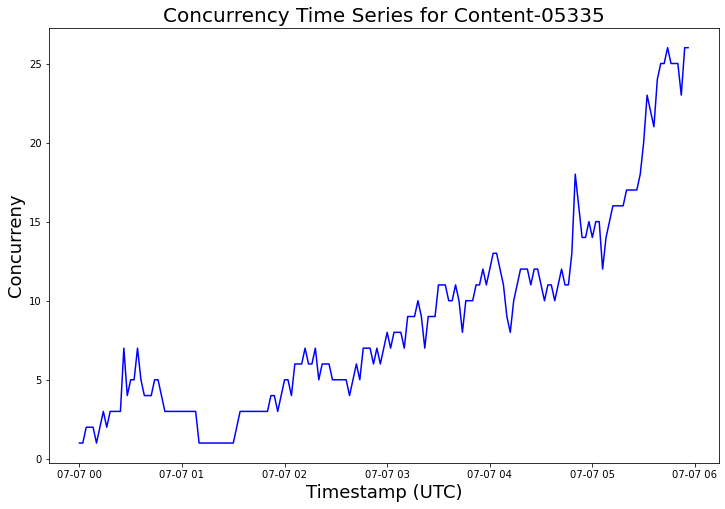

In [17]:
# Content 05335 dataframe and plotting concurrency
content = concurrency_df[concurrency_df.index.get_level_values('content') == 'content-05335']

plt.figure(figsize=(12,8))
plt.plot(content.index.get_level_values('readableDate'), content['concurrency'], 'b-')
plt.xlabel('Timestamp (UTC)', fontsize=18)
plt.ylabel('Concurreny', fontsize=18)
plt.title('Concurrency Time Series for Content-05335', fontsize=20)

### 4.3 
What is the average performance measured when the concurrency is lower
than 10?

In [18]:
# Dataframe for concurrencies less than 10 and resetting index for ease in looping over rows
less_10 = concurrency_df[concurrency_df['concurrency'] < 10]
less_10 = less_10.reset_index(level=0, drop=True)
less_10 = less_10.reset_index()

In [19]:
less_10.describe() 
# Note that the majority of the data for concurrencies less than 10 has a concurrency of 1

,p2p_total,cdn_total,concurrency
count,3.358550e+05,3.358550e+05,335855.000000
mean,9.293044e+06,7.814622e+06,1.089881
std,2.507707e+07,1.130071e+07,0.458941
min,0.000000e+00,0.000000e+00,1.000000
25%,0.000000e+00,0.000000e+00,1.000000
50%,0.000000e+00,3.901440e+06,1.000000
75%,9.259188e+06,1.154583e+07,1.000000
max,8.637543e+08,2.751384e+08,9.000000


In [20]:
# Calculate concurrency for each 2 minute interval and store in a list
utility_rates = []

for i in range(0,len(less_10)):
    utility_rates.append(get_utility_rate(less_10['p2p_total'].iloc[i], less_10['cdn_total'].iloc[i]))

In [21]:
# Remove any nan utility rates before averaging
cleaned_utility_rates = [x for x in utility_rates if ~np.isnan(x)]

In [22]:
print('The average performance measured when the concurrency is lower than 10 is', np.mean(cleaned_utility_rates))

The average performance measured when the concurrency is lower than 10 is 0.40890922447555267


### 4.4 
Starting from which concurrency can we say there is a 75% chance that the performance on a content is higher than 80%?

In [23]:
# Defining a function to plot boxplots for distribution of performance score based on concurrency
def concurrency_to_boxplot(df, concurrency):
    # Subset data by concurrency value
    subset = df[df['concurrency'] == concurrency]
    subset = subset.reset_index(level=0, drop=True)
    subset = subset.reset_index()
    
    # Get all utility rates for subsetted data
    utility_rates = []
    
    for i in range(0,len(subset)):
        utility_rates.append(get_utility_rate(subset['p2p_total'].iloc[i], subset['cdn_total'].iloc[i]))
        
    # Remove any nan utility rates before averaging
    cleaned_utility_rates = [x for x in utility_rates if ~np.isnan(x)]
    
    # Plotting the boxplot
    plt.figure(1, figsize=(9, 6))
    plt.boxplot(cleaned_utility_rates, showmeans=True)
    plt.ylabel('Performance Score (Utility Rate)', fontsize = 18)
    plt.title('Distribution of Performance Scores for Concurrency of ' + str(concurrency), fontsize = 18)

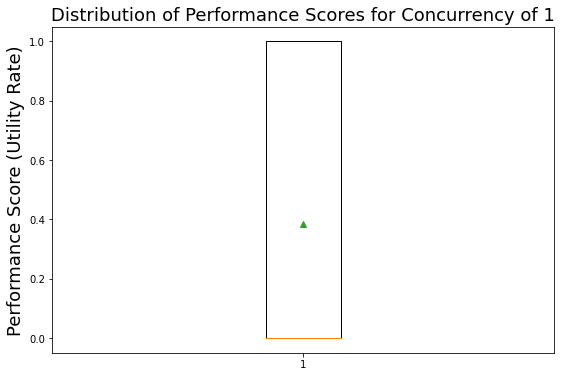

In [24]:
concurrency_to_boxplot(concurrency_df, 1)

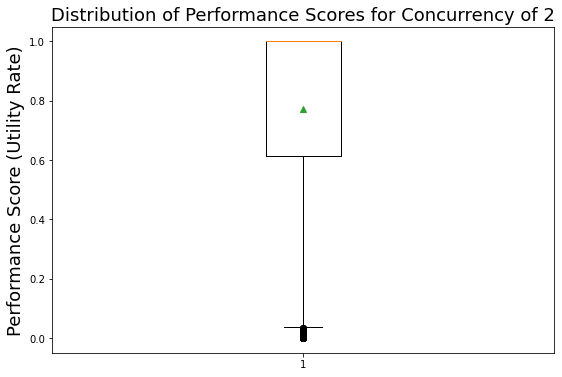

In [25]:
concurrency_to_boxplot(concurrency_df, 2)

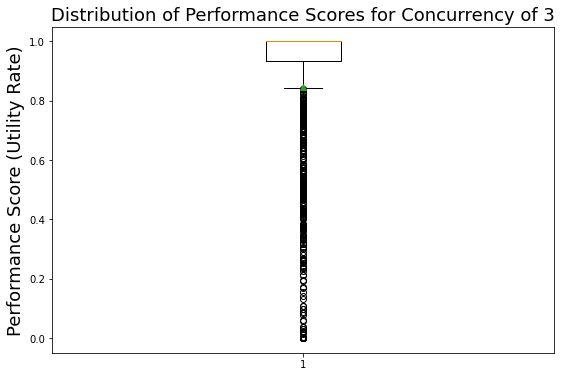

In [26]:
concurrency_to_boxplot(concurrency_df, 3)

Answer: Starting at a concurrency of 3, we can say there is a 75% chance that the performance on a content is higher than 80%. The 25th percentile shown in a boxplot represents the point where 75% of the data falls above that value. In the boxplots above, a concurrency of 3 is the first value where the 25th percentile falls above 0.80.